## Pool of low oxygen concentration
Frames and movie

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.animation as animation
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns

import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    
hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

In [5]:
# Cross-shelf velocity, Plot1
def Plot1(gs_ax,t,Tr,xx,zz,textt, Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr: tracer concentration sliced in x-z (nt,nz,nx)
       t: time index.
       xx: x coords, sliced
       yy: y coords, sliced
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(xx/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    cont = ax.contour(xx/1000,zz,Tr,
                      Csb,
                      colors='k')
    ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    ax.text(0.1,-0.3,'%s at day %1.1f'%(textt, t/2.),fontsize=16,transform=ax.transAxes)
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.tick_params(axis='y', pad=1)
    
def Plot2(gs_ax,t,Tr,yy,zz,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    mesh = ax.contourf(yy/1000,zz,Tr,
                       csU,
                       cmap=cmap_name)
    cont = ax.contour(yy/1000,zz,Tr,
                      Csb,
                      colors='k')
    if tt == 0:
        cbar_ax = ff.add_axes([0.91, 0.62, 0.016, 0.26])
        cb = plt.colorbar(mesh, cax=cbar_ax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f')
        cb.ax.yaxis.set_tick_params(pad=1)

        ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    
    ax.set_facecolor((205/255.0, 201/255.0, 201/255.0))
    #ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    ax.tick_params(axis='y', pad=1)
    
def Plot3(ff,gs_ax,t,ConcFilt,xx,yy,xind,yind,depth,Trmin=0,Trmax=2):
    
    ax = plt.subplot(gs_ax)
    
    mesh = ax.contourf(xx/1000,yy/1000,ConcFilt,
                       21, 
                      vmax=Trmax, 
                      vmin=Trmin,
                      cmap=cmap_name2)
    cont = ax.contour(xx/1000,yy/1000,ConcFilt,
                      Csb,
                      colors='k')
       
    ax.set_facecolor((180/255.0, 175/255.0, 175/255.0))
    
    ax.text(0.02,0.9,'Shelf bottom',transform=ax.transAxes,color='w')
    SB = ax.contour(xx/1000,yy/1000,
                    depth,
                    [50,75,100,125,150,200,250,300,350,400,450,500],
                    colors=['0.5','0.5','0.5','0.5','0.1','0.5','0.5','0.5','0.5','0.5','0.5','0.5'],
                    linewidths=[0.75] )
    
    ax.axhline(Y[yind]/1000, color='0.3', linestyle='--')
    ax.axvline(X[xind]/1000, color='0.3', linestyle='--')
    
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)

In [6]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*(nz-1) - BottomInd) # Get index of unreversed z axis
  
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf))


In [7]:
def next_frame(time,ff, trac, Trmin=78, Trmax=300,textt = 'Oxygen concentration ($\mu$mol/kg)'):
    
    tt = starttime + time 
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = nbl.variables[trac][tt,zslice,yind,xslice] 
        tr_plot1 = np.ma.masked_array(tr, maskC[zslice, yind, xslice])
        print(np.min(tr_plot1),np.max(tr_plot1))
            
        tr = nbl.variables[trac][tt,zslice_2,yslice,xind]
        tr_plot2 = np.ma.masked_array(tr, maskC[zslice_2,yslice, xind])
        print(np.min(tr_plot2),np.max(tr_plot2))
            
        concFilt = ConcAreaFunc(nbl.variables[trac][tt,:,:,:],hFacC,rA,Depth,104,sbdepth=-152.5)

    gs0 = gspec.GridSpec(2, 1, height_ratios=[0.5,1], hspace=0)
    gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.12)
    

    Plot1(gs01[0],tt,tr_plot1,X[xslice],Z[zslice],textt, Trmin=Trmin, Trmax=Trmax)
    Plot2(gs01[1],tt,tr_plot2,Y[yslice],Z[zslice_2], Trmin=Trmin, Trmax=Trmax)
    Plot3(ff,gs0[1],tt,concFilt[yslice_bac,xslice_bac],X[xslice_bac],Y[yslice_bac],
          xind,yind,Depth[yslice_bac,xslice_bac],
          Trmin=Trmin,Trmax=Trmax)
   
    #plt.tight_layout()

def next_frame_anom(time,ff, trac, Trmin=0, Trmax=1, textt = 'Oxygen concentration ($\mu$mol/kg)'):
    
    tt = starttime + time 
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as nc:
        
            trNoC = nc.variables[trac][tt,zslice,yind,xslice]
            tr0NoC = nc.variables[trac][0,zslice,yind,xslice] 
            tr = nbl.variables[trac][tt,zslice,yind,xslice] 
            tr_plot1 = np.ma.masked_array(100*(tr-trNoC)/tr0NoC, maskCNoC[zslice, yind, xslice])
            
            trNoC = nc.variables[trac][tt,zslice_2,yslice,xind]
            tr0NoC = nc.variables[trac][0,zslice_2,yslice,xind]
            tr = nbl.variables[trac][tt,zslice_2,yslice,xind]
            tr_plot2 = np.ma.masked_array(100*(tr-trNoC)/tr0NoC, maskCNoC[zslice_2,yslice, xind])
            
            anom = np.ma.masked_array(nbl.variables[trac][tt,:,:,:]-nc.variables[trac][tt,:,:,:], mask=maskCNoC)
            anom0 = np.ma.masked_array(nbl.variables[trac][0,:,:,:], mask=maskCNoC)
            
            concFilt = ConcAreaFunc(anom,hFacCNoC,rA,Depth,104, sbdepth=-152.5)
            concFilt0 = ConcAreaFunc(anom0,hFacCNoC,rA,Depth,104, sbdepth=-152.5)


    gs0 = gspec.GridSpec(2, 1, height_ratios=[0.5,1], hspace=0)
    gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.12)
    
    Plot1(gs01[0],tt,tr_plot1,X[xslice],Z[zslice],textt, Trmin=Trmin, Trmax=Trmax)
    Plot2(gs01[1],tt,tr_plot2,Y[yslice],Z[zslice_2], Trmin=Trmin, Trmax=Trmax)
    Plot3(ff,gs0[1],tt,100*concFilt[yslice_bac,xslice_bac]/concFilt0[yslice_bac,xslice_bac],
          X[xslice_bac],Y[yslice_bac],
          xind,yind,Depth[yslice_bac,xslice_bac],
          Trmin=Trmin,Trmax=Trmax)
   
    #plt.tight_layout()



123.39377 258.6469
92.549805 258.6469


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


123.49969 258.3424
92.603264 258.34396
111.97522 258.0449
92.76164 258.062
86.82509 257.76242
92.45152 257.83627
77.66763 257.49838
85.57236 257.5376
72.24447 257.18588
78.31743 257.3302
68.91159 256.91003
75.08185 257.07077
68.19071 256.65988
73.67012 256.90585
67.95252 256.41733
74.25313 256.69305
67.254456 256.15085
74.5006 256.59067
67.069626 255.68791
73.61008 256.45187
66.80924 255.45207
73.50747 256.36508
67.144585 255.23506
73.86494 256.1986
67.433754 255.03897
74.67641 256.03702
67.77179 254.81827
76.18858 255.8602
67.45034 254.61089
76.833046 255.68837
67.49608 254.39911
76.67887 255.50917
67.5812 254.08105
76.72102 255.33374
67.596886 253.46983
76.83613 255.13043


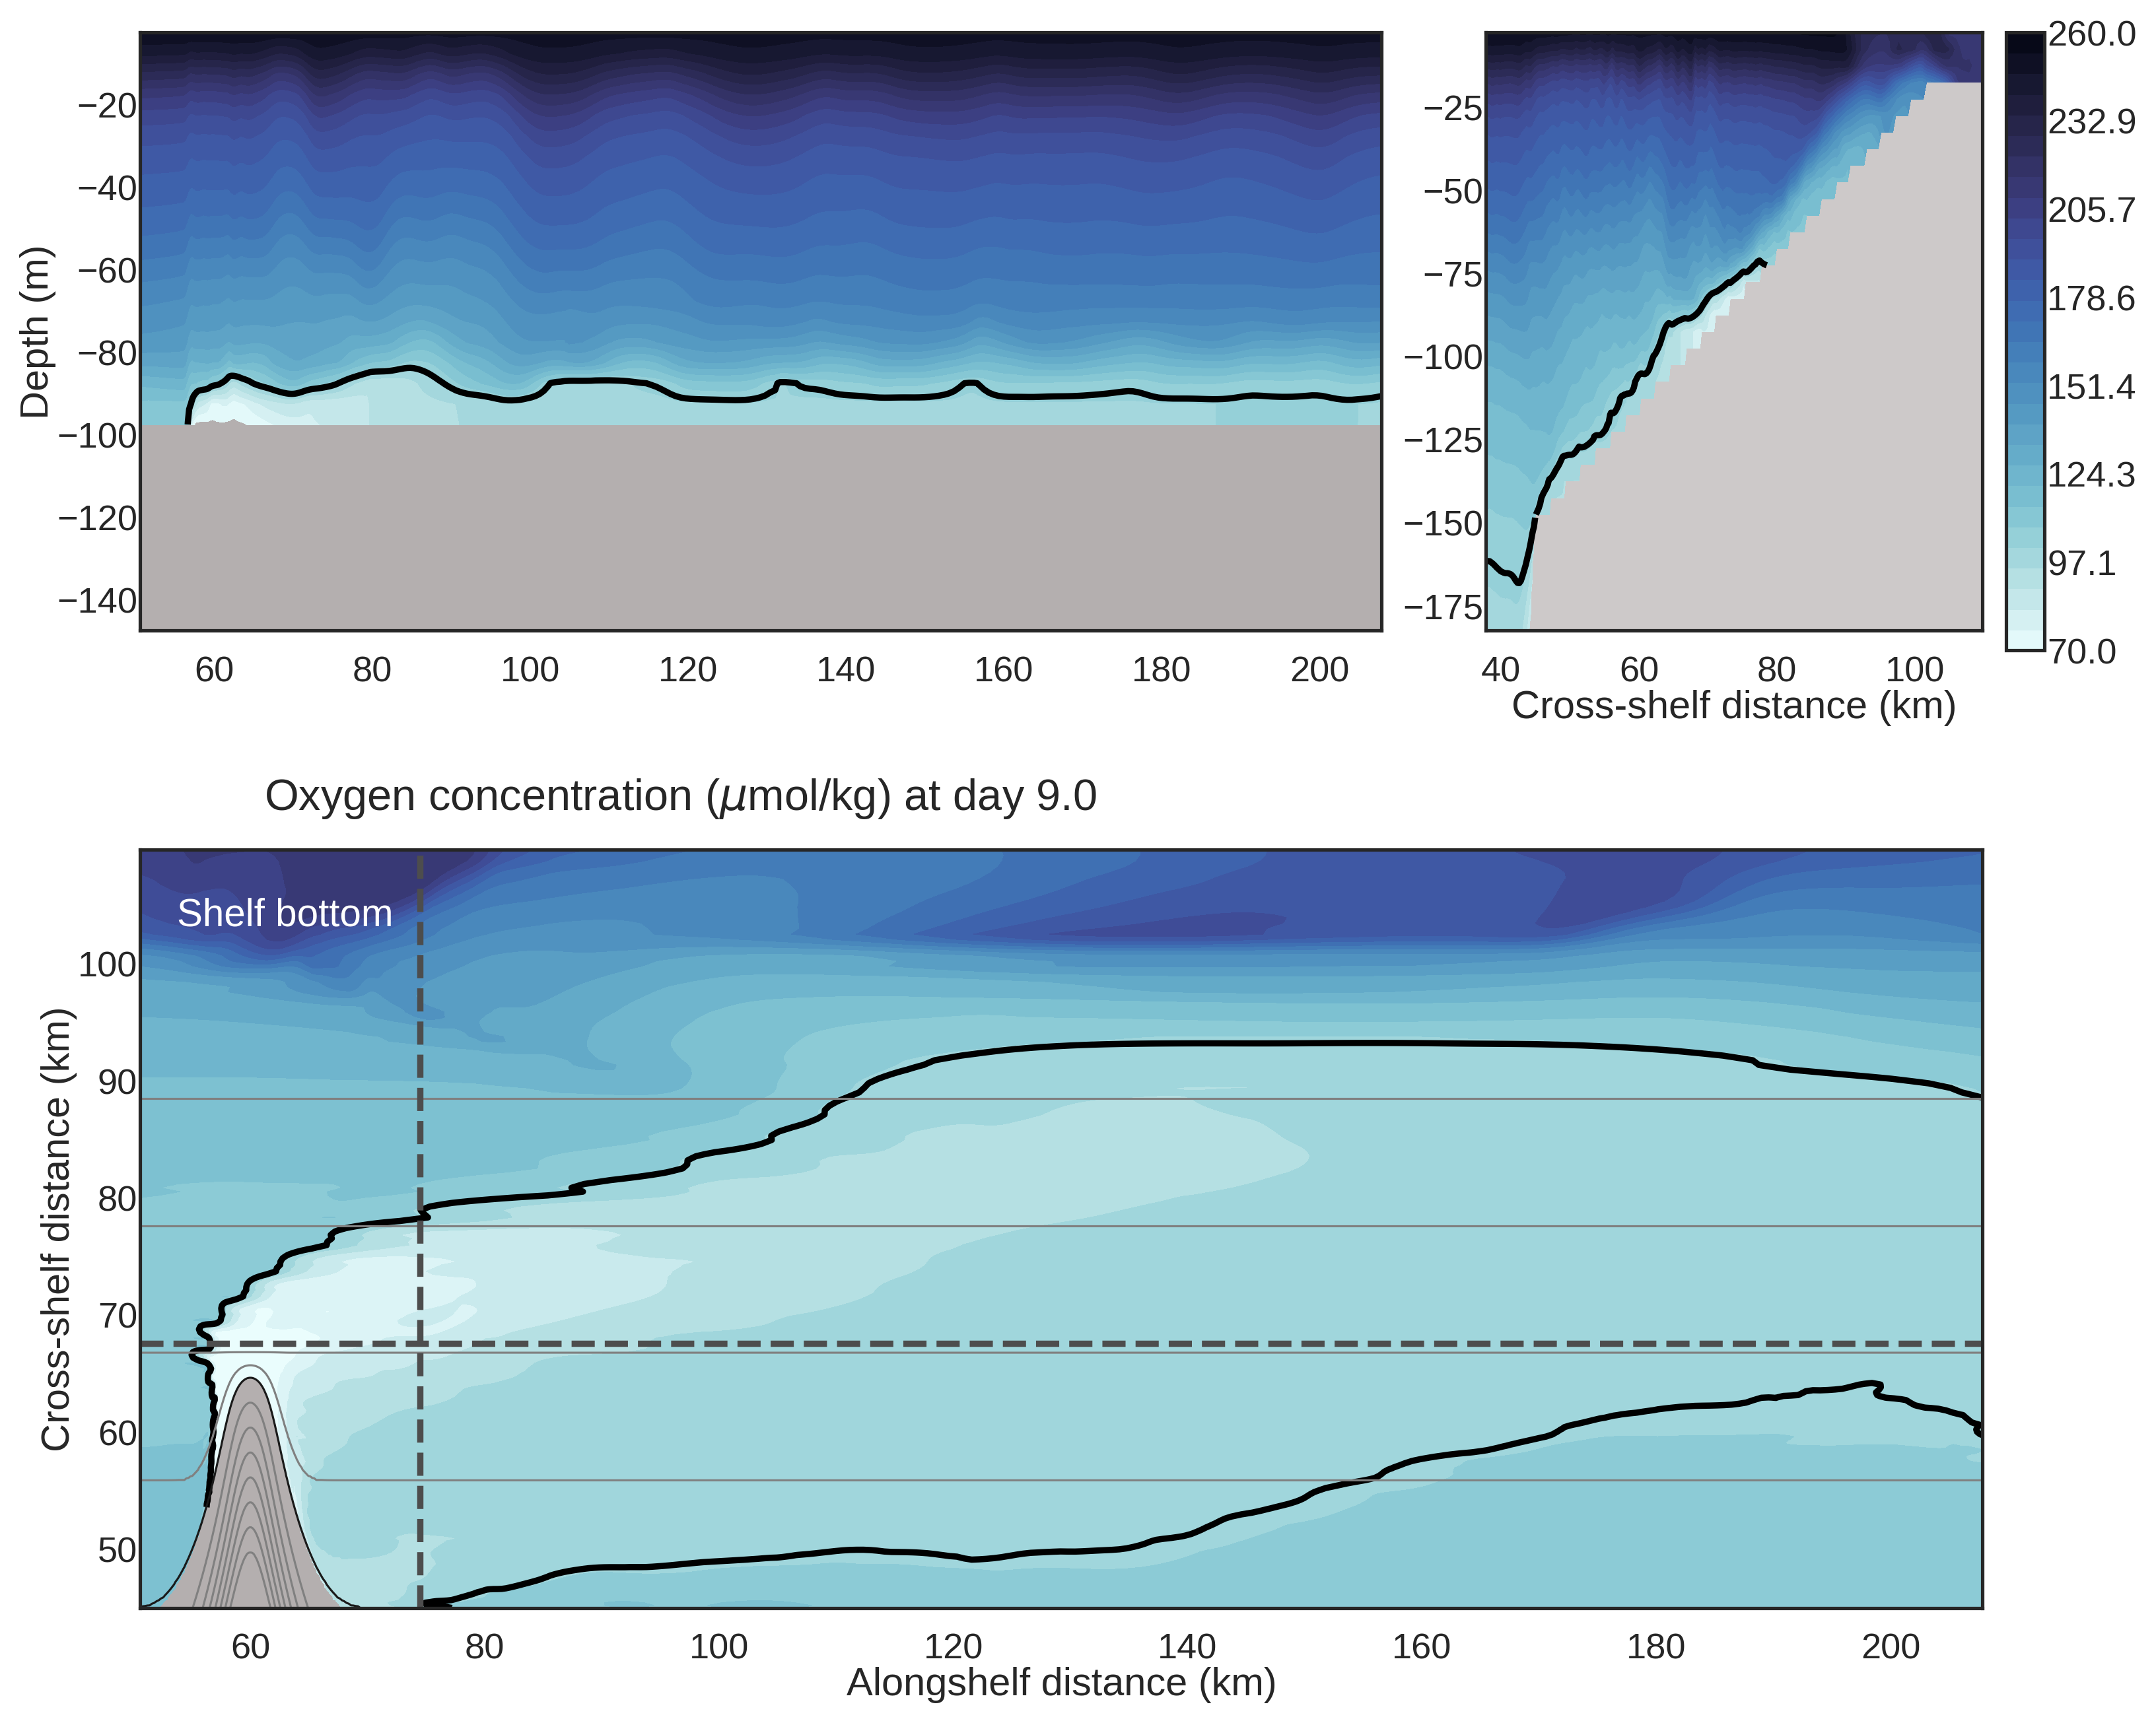

In [8]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 260
yind = 241 # y index for alongshore cross-section
zind = 38

zslice = slice(0,30)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr03' # Linear

cmap_name = cmo.cm.ice_r
cmap_name2 = cmo.cm.ice_r
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0

starttime = 0

ff = plt.figure(figsize=(12,12),dpi=dpi)

with Dataset(ptracers_file, 'r') as nbl:
    Csb = nbl.variables[trac][0,30,50,180].data
   
for tt in range(19):
    
    next_frame(tt,ff, trac, Trmin=70.0, Trmax=260)
    frame_name2 = ('frames/oxy_AST_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png', bbox_inches='tight')



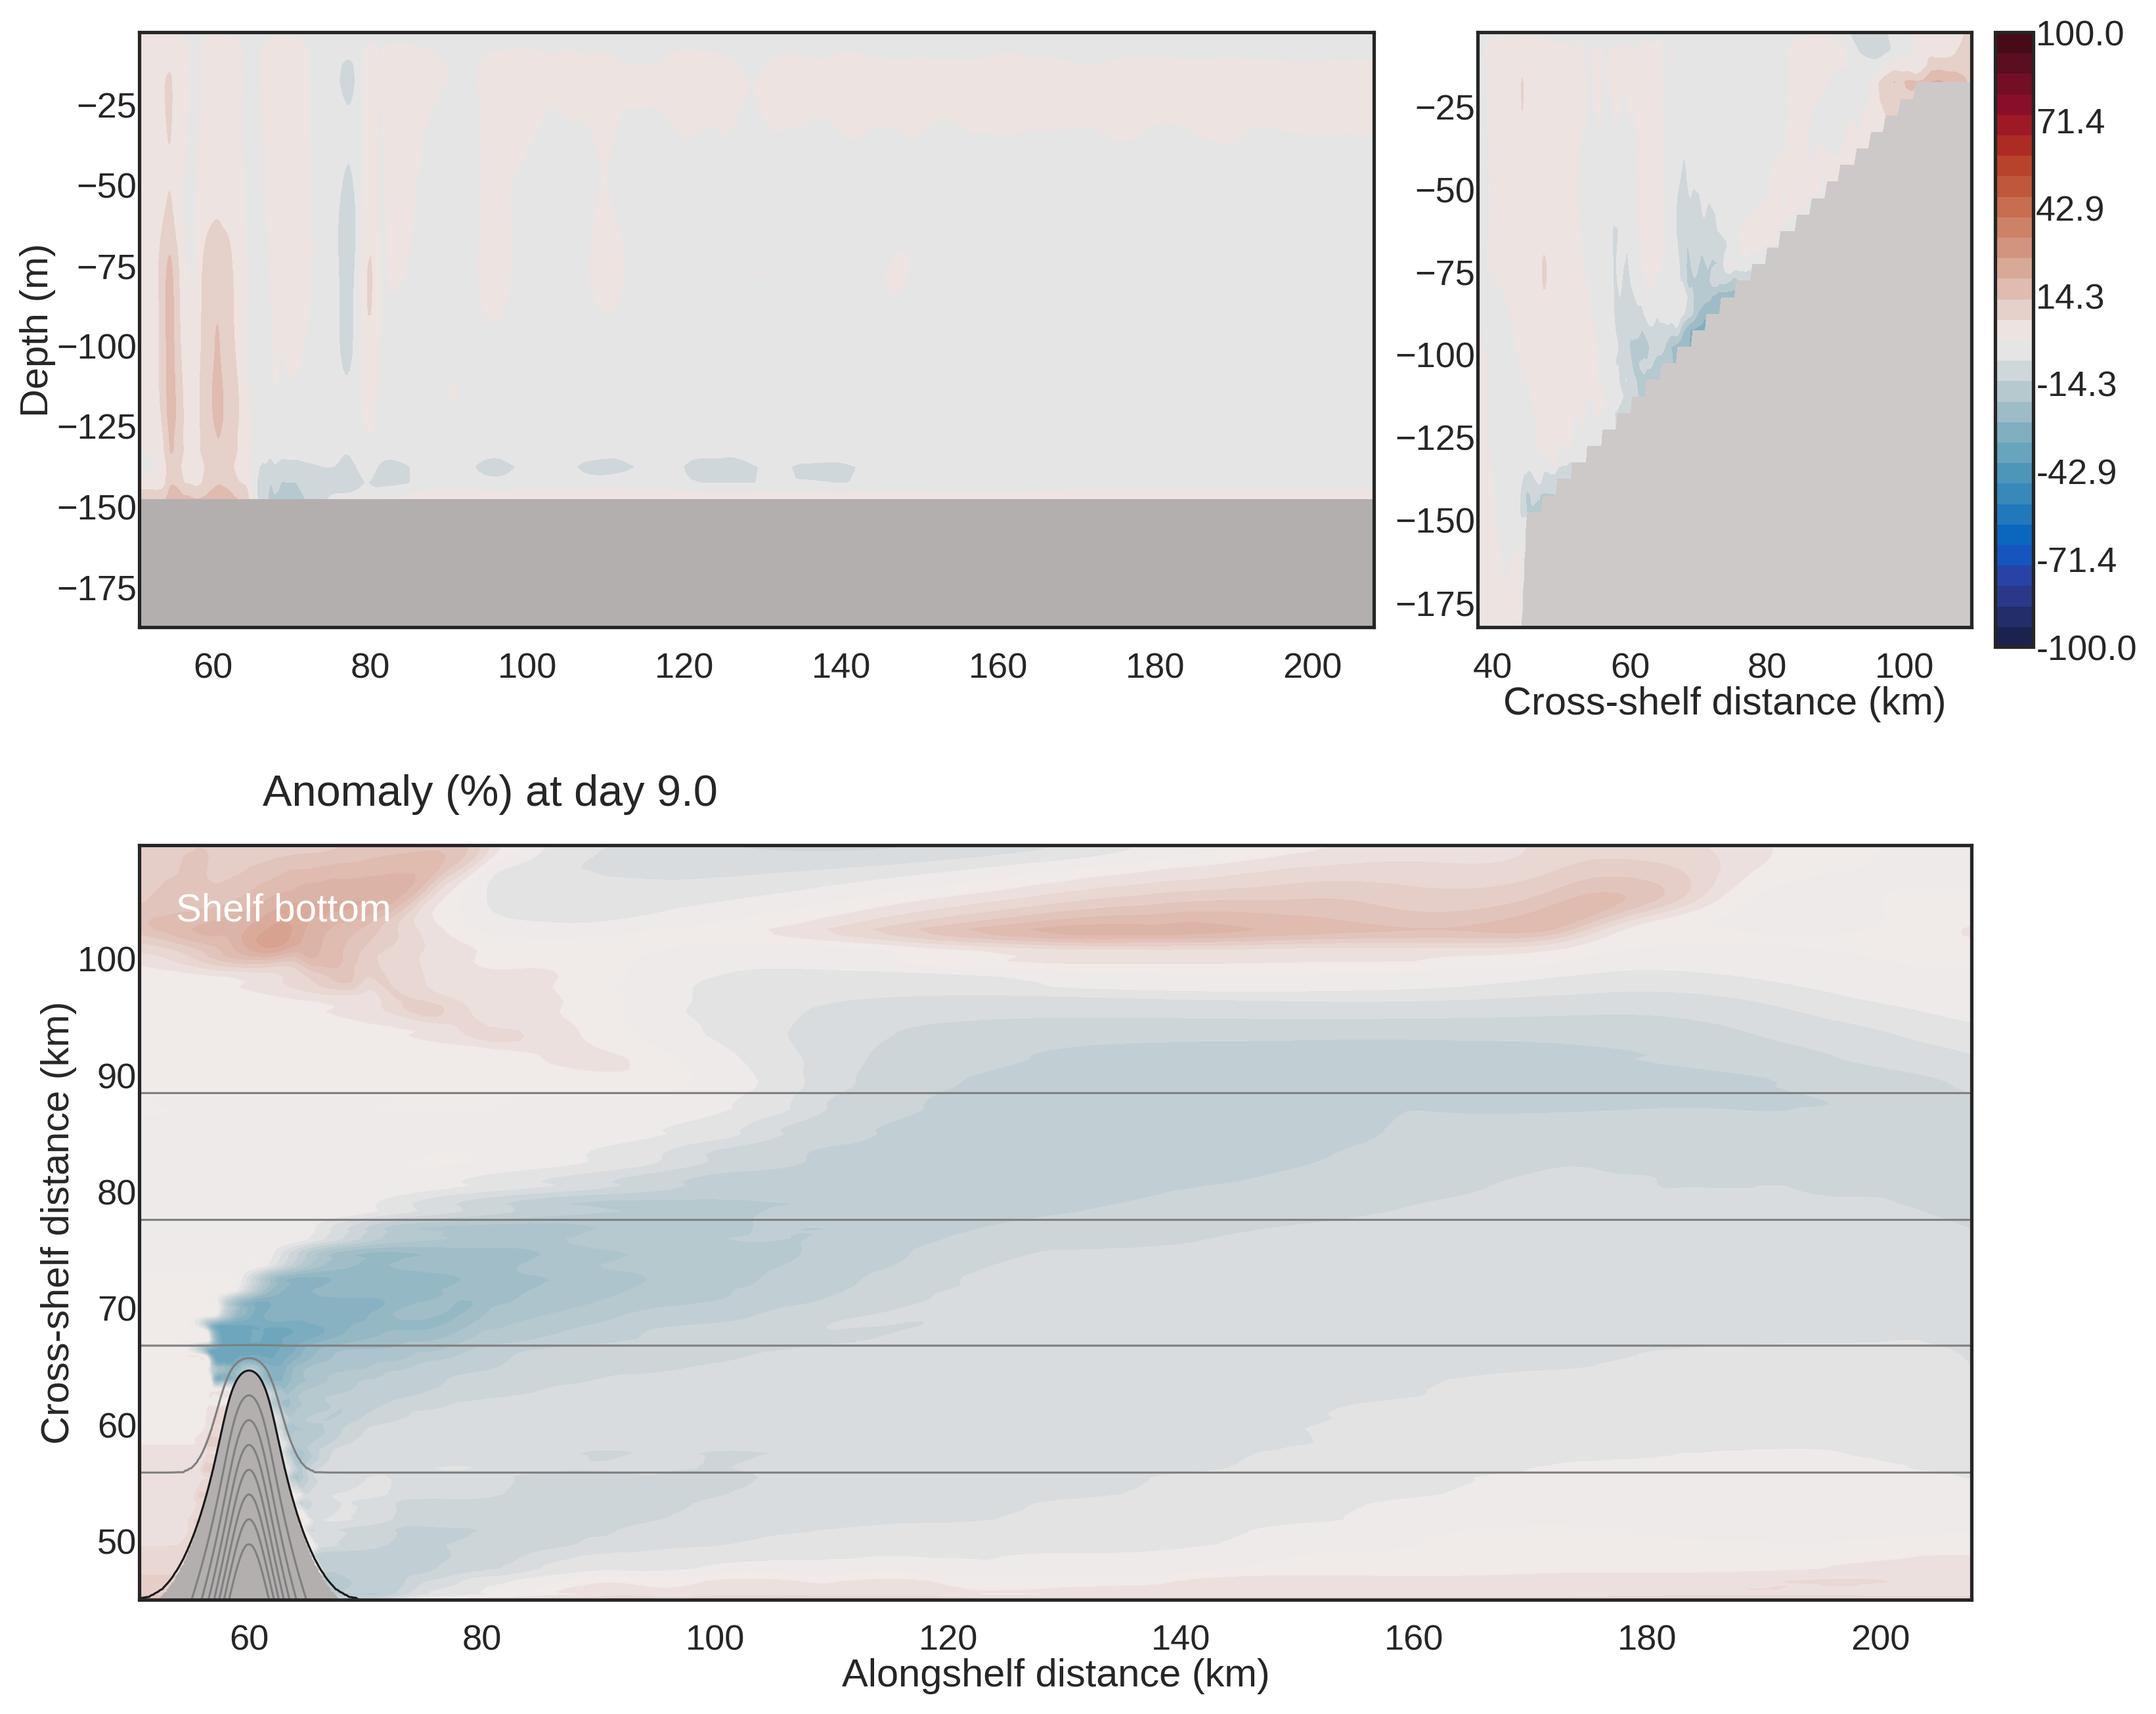

In [15]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 260
yind = 241 # y index for alongshore cross-section
zind = 38

zslice = slice(0,30)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr03' # linear

title_text = 'Anomaly (%)'

cmap_name = cmo.cm.balance
cmap_name2 = cmo.cm.balance
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0

starttime = 0
ff = plt.figure(figsize=(12,12),dpi=dpi)
Csb=0   
for tt in range(19):
    
    next_frame_anom(tt,ff, trac,Trmin=-100, Trmax=100, textt=title_text)
    frame_name2 = ('frames/OxyAnom_AST_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png',bbox_inches='tight')
    


### Animations

123.39377 258.6469
92.549805 258.6469


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


123.39377 258.6469
92.549805 258.6469
123.49969 258.3424
92.603264 258.34396
111.97522 258.0449
92.76164 258.062
86.82509 257.76242
92.45152 257.83627
77.66763 257.49838
85.57236 257.5376
72.24447 257.18588
78.31743 257.3302
68.91159 256.91003
75.08185 257.07077
68.19071 256.65988
73.67012 256.90585
67.95252 256.41733
74.25313 256.69305
67.254456 256.15085
74.5006 256.59067
67.069626 255.68791
73.61008 256.45187
66.80924 255.45207
73.50747 256.36508
67.144585 255.23506
73.86494 256.1986
67.433754 255.03897
74.67641 256.03702
67.77179 254.81827
76.18858 255.8602
67.45034 254.61089
76.833046 255.68837
67.49608 254.39911
76.67887 255.50917
67.5812 254.08105
76.72102 255.33374
67.596886 253.46983
76.83613 255.13043
123.39377 258.6469
92.549805 258.6469


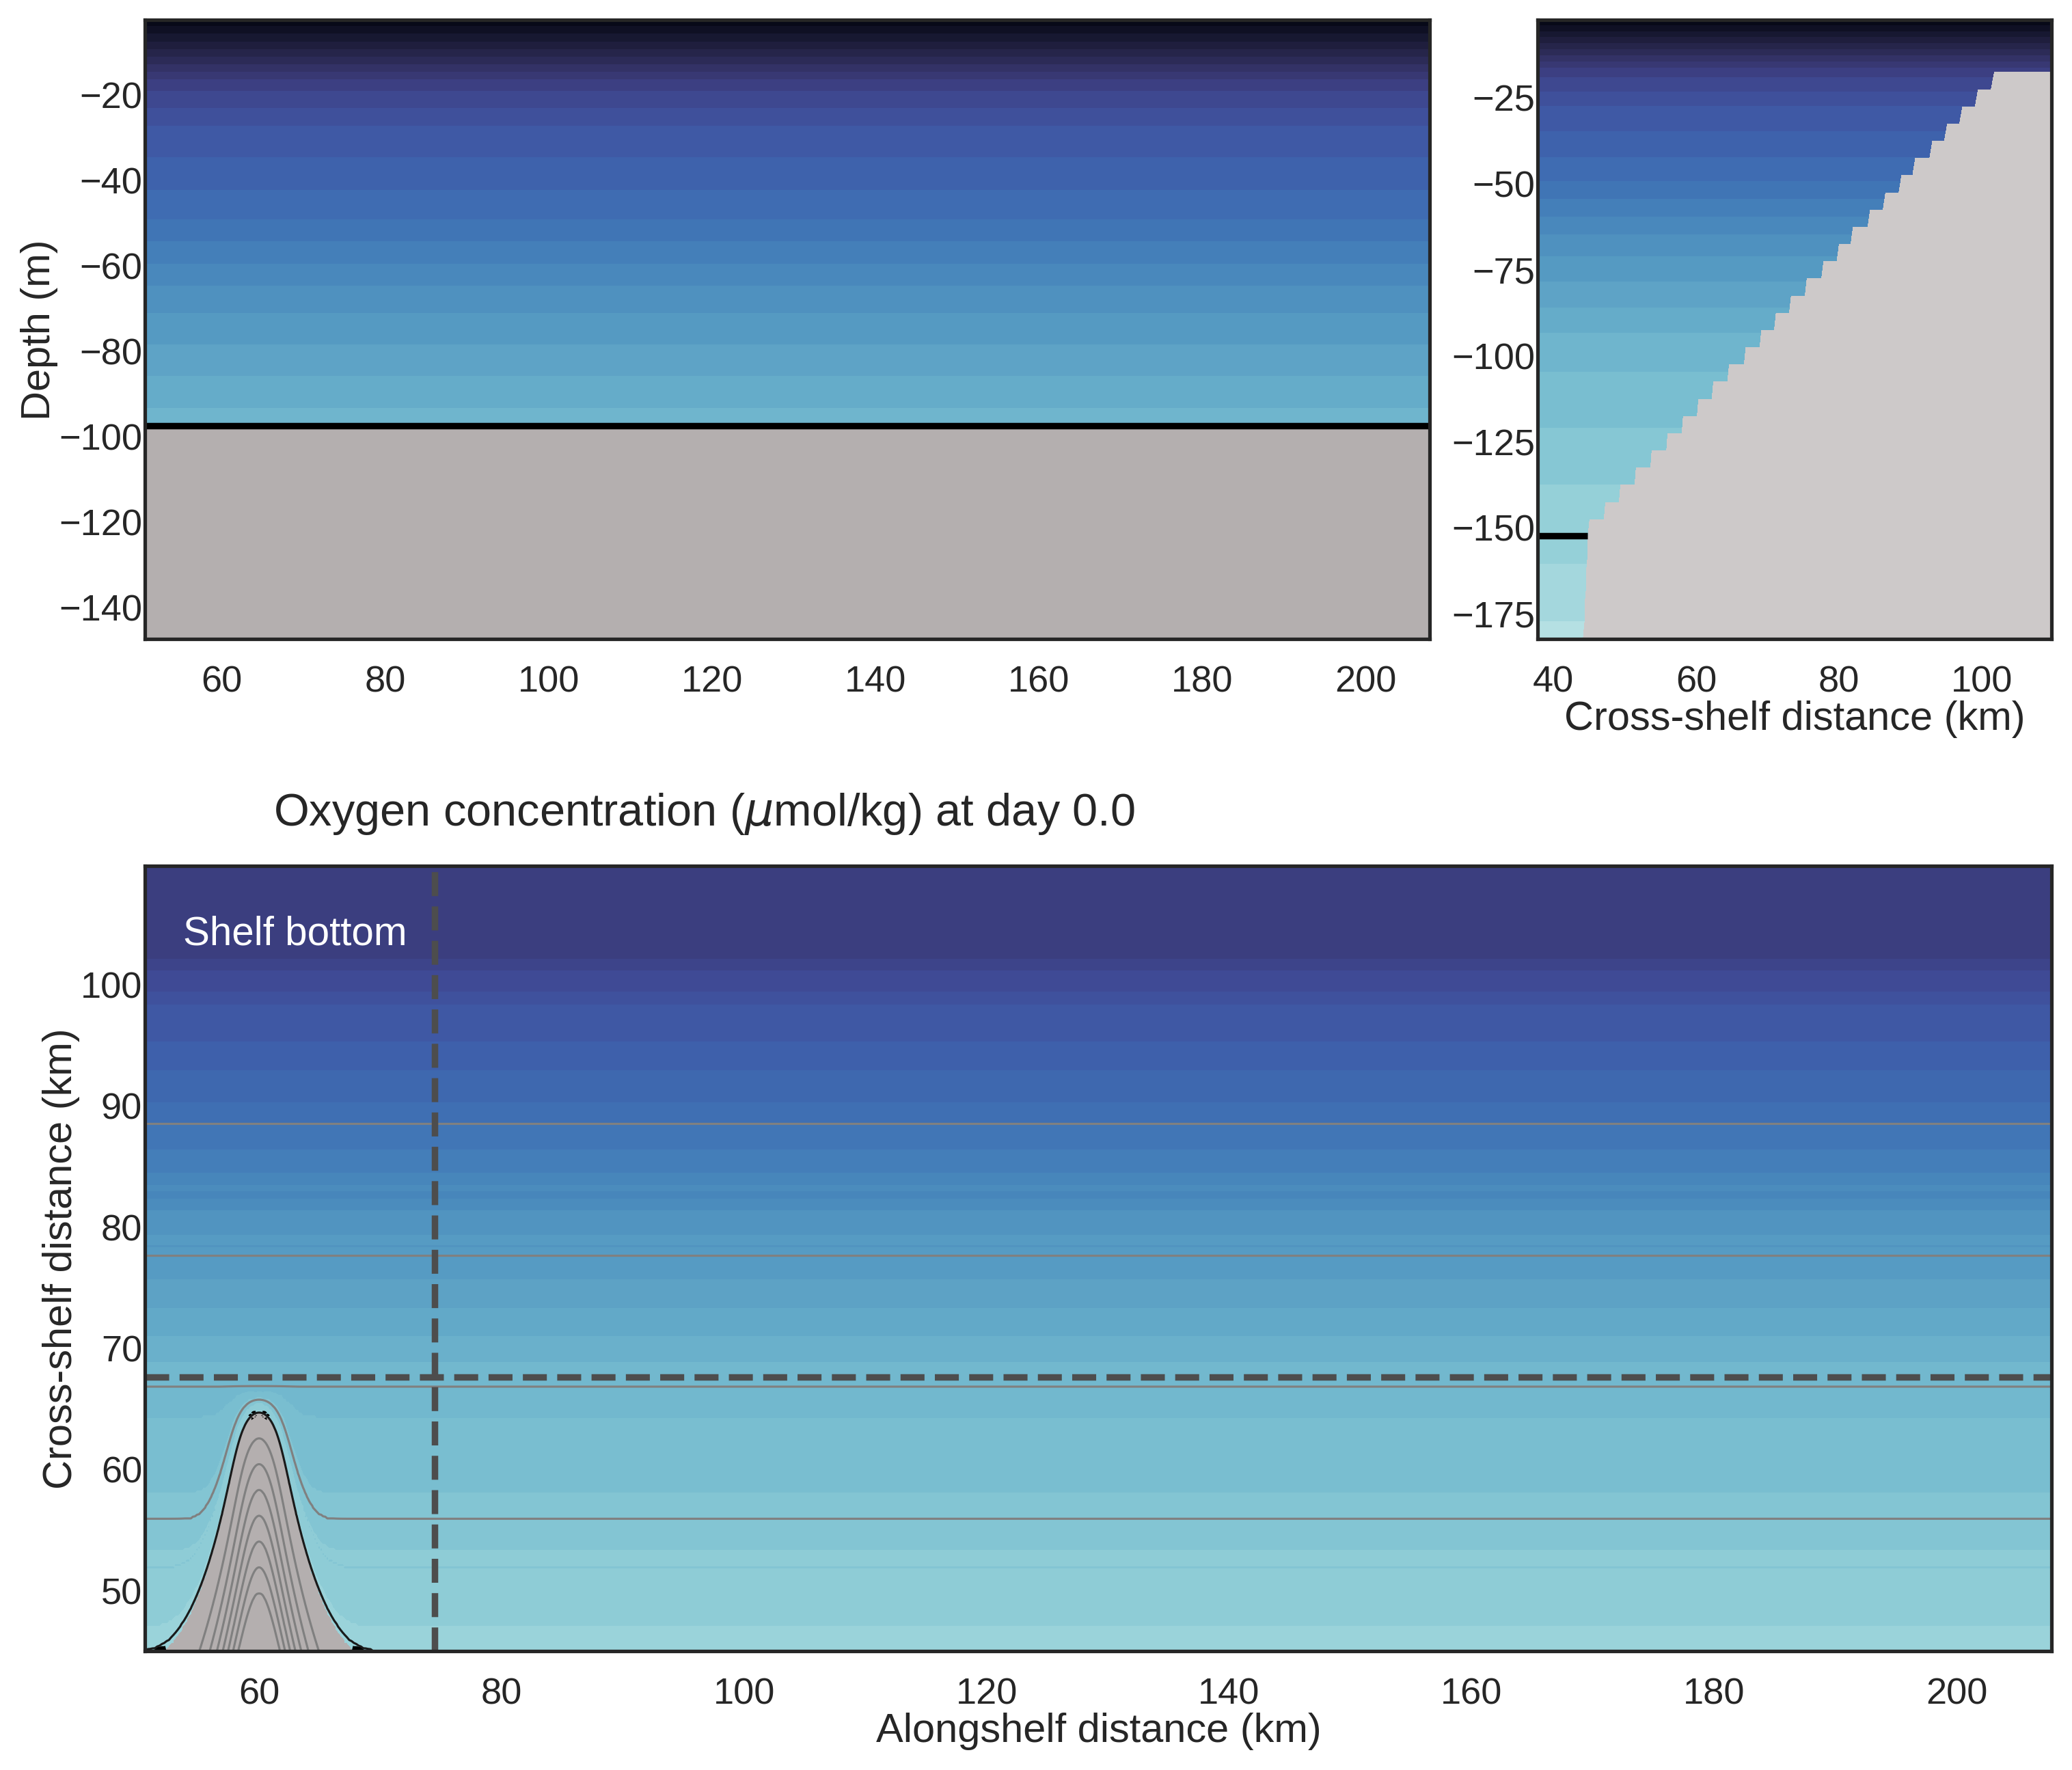

In [9]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 260
yind = 241 # y index for alongshore cross-section
zind = 38

zslice = slice(0,30)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr03' # Oxygen

cmap_name = cmo.cm.ice_r
cmap_name2 = cmo.cm.ice_r
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0

starttime = 0

ff = plt.figure(figsize=(12,12),dpi=dpi)
with Dataset(ptracers_file, 'r') as nbl:
    Csb = nbl.variables[trac][0,30,50,180].data

def init():
    next_frame(0,ff, trac,  Trmin=70, Trmax=260)
def animate(t):
    next_frame(t,ff, trac,  Trmin=70, Trmax=260)

    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(ff, animate, init_func=init,frames=19,repeat=False)
anim.save('Oxy_AST.mp4', writer=writer)

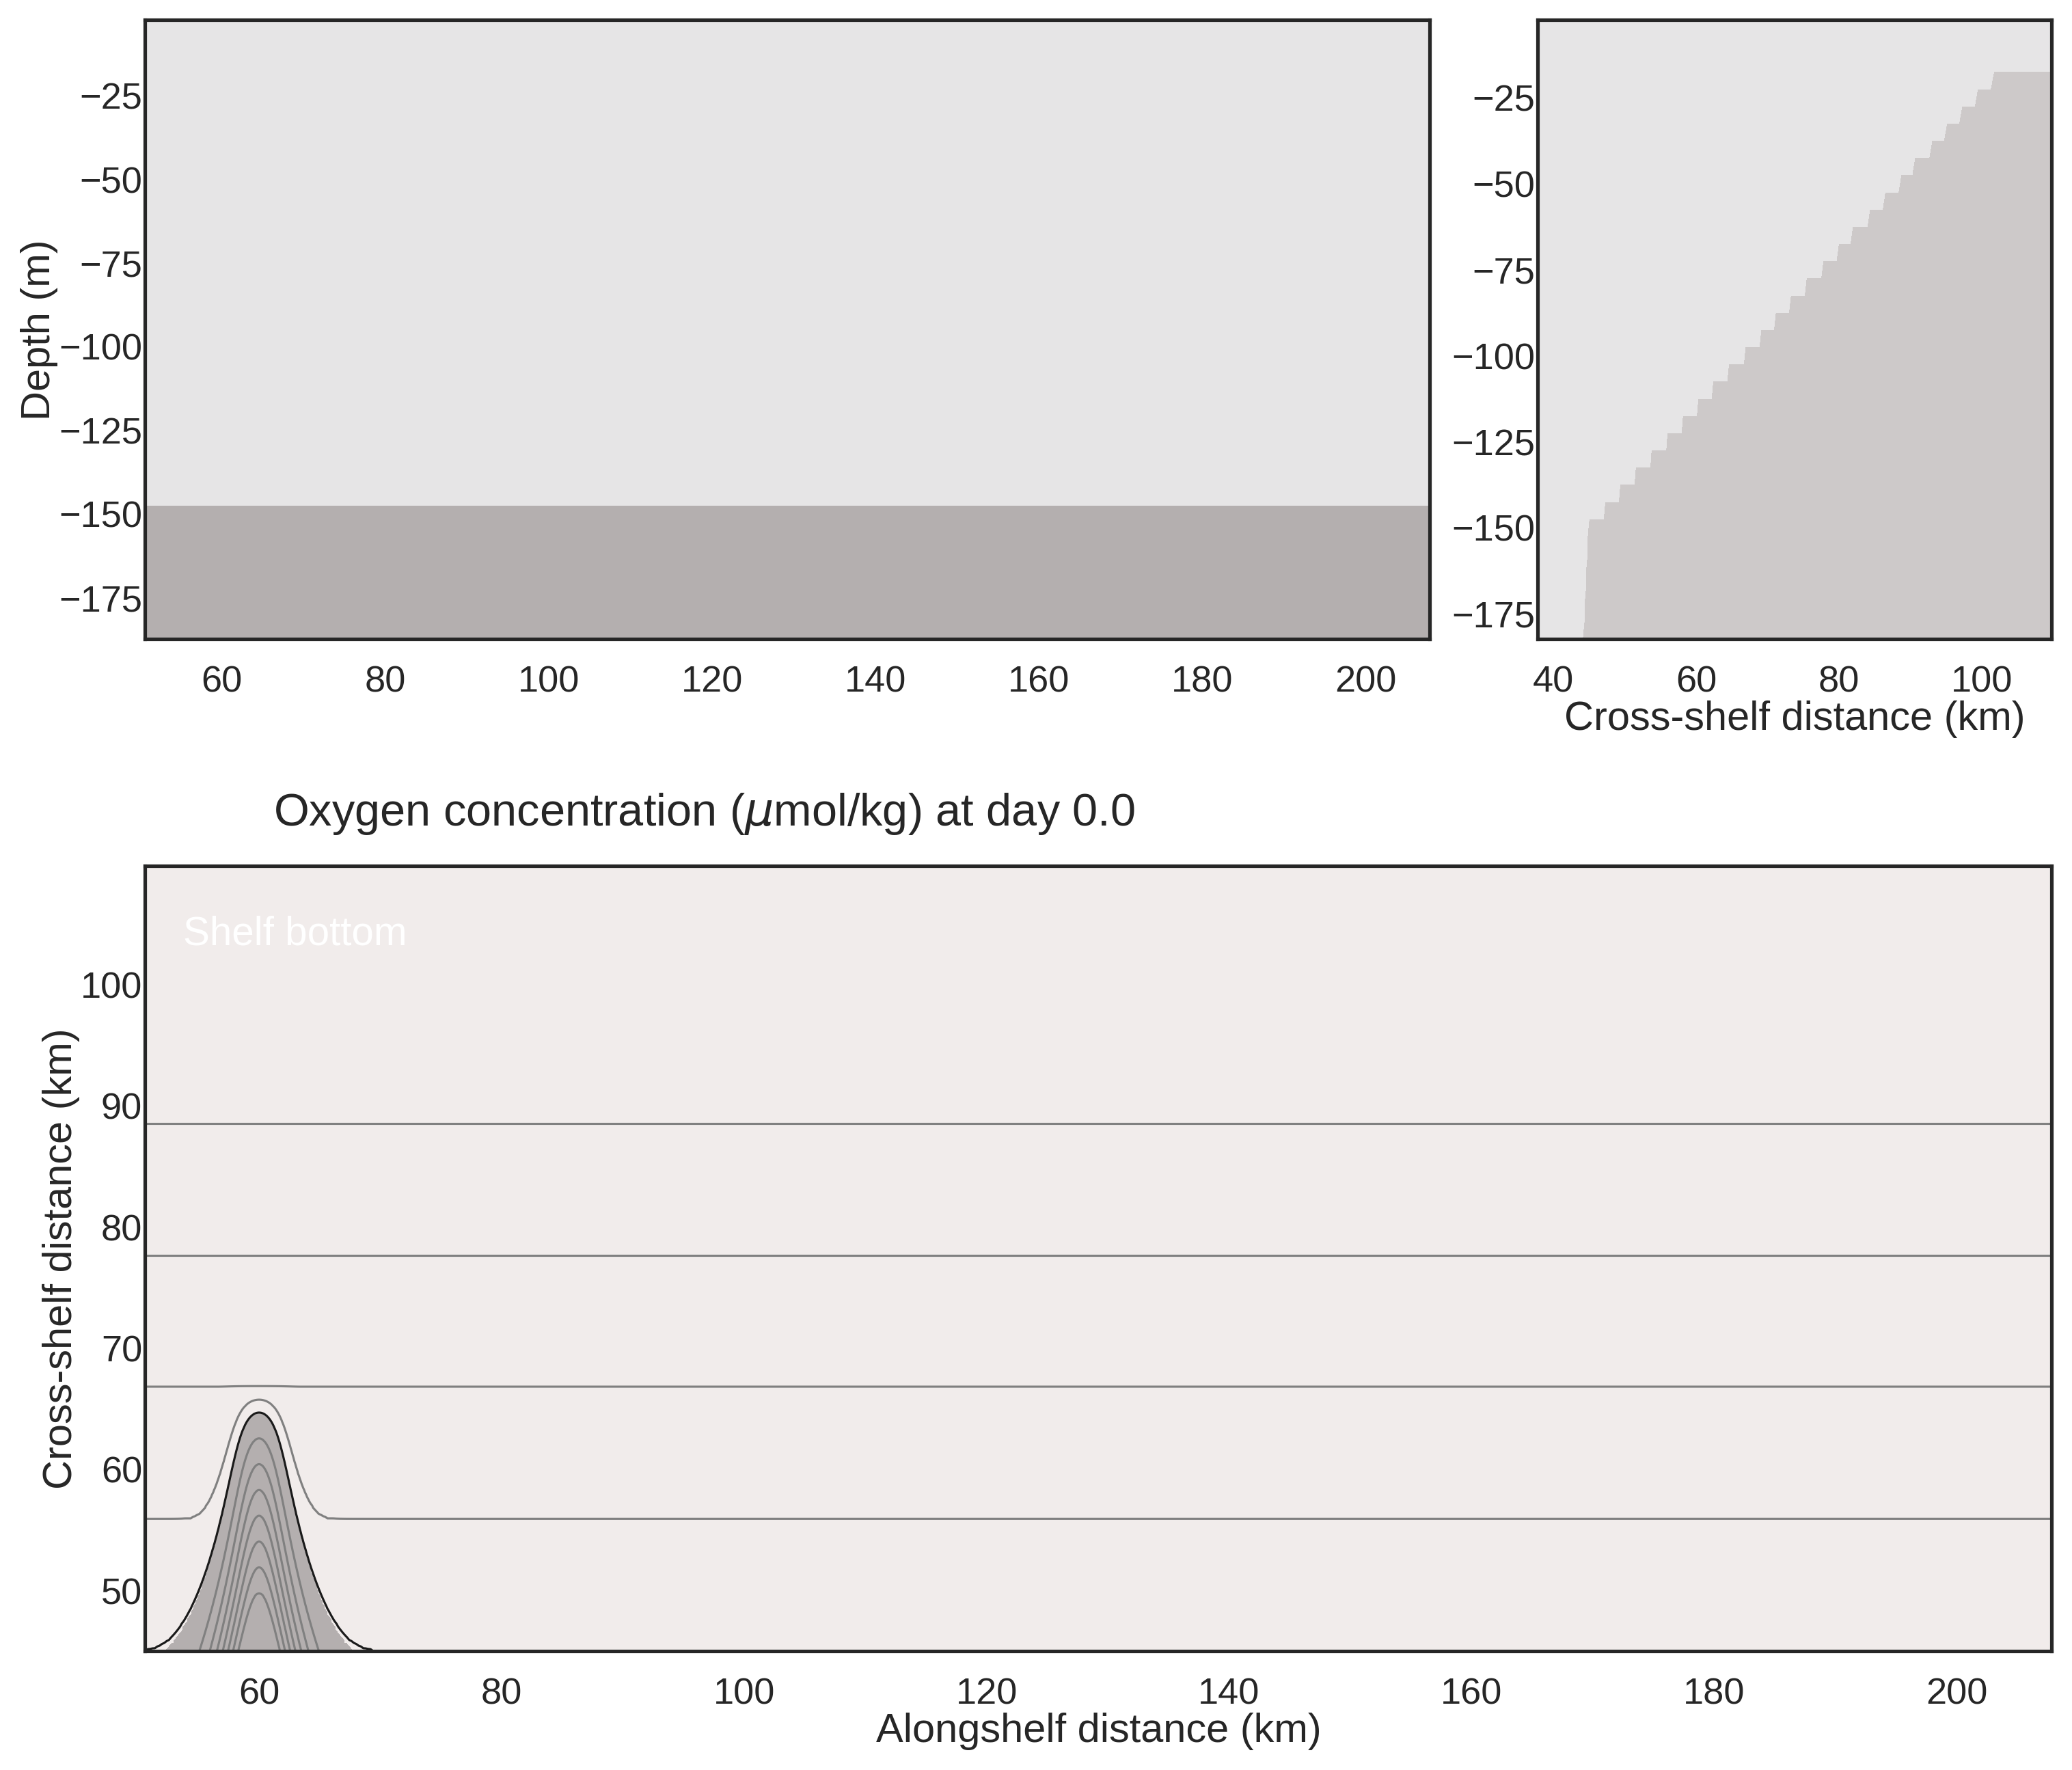

In [17]:
xslice=slice(120,500)
yslice=slice(100,360)

xind = 260
yind = 241 # y index for alongshore cross-section
zind = 38

zslice = slice(0,30)

# plot2
zslice_2 = slice(0,37)

# plot 3
yslice_bac = slice(129,360)
xslice_bac = slice(120,500)

# frames for beamer animation
dpi = 300

trac = 'Tr03' # oxygen

title_text = 'Anomaly (%)'

cmap_name = cmo.cm.balance
cmap_name2 = cmo.cm.balance
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0

starttime = 0
ff = plt.figure(figsize=(12,12),dpi=dpi)
Csb = 0
def init():
    next_frame_anom(0,ff, trac, Trmin=-100, Trmax=100)
def animate(t):
    next_frame_anom(t,ff, trac, Trmin=-100, Trmax=100)

    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(ff, animate, init_func=init,frames=19,repeat=False)
anim.save('Oxy_anom_AST.mp4', writer=writer)